In [1]:
#instalando o pd arima
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 13.6 MB/s 
     |████████████████████████████████| 9.8 MB 58.9 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


# 0. CARREGANDO AS BIBLIOTECAS

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from statsmodels.tsa.api import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_log_error
from pmdarima.metrics import smape

import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. CARREGANDO AS BASES DE DADOS

In [4]:
df_item_categories = pd.read_csv("/content/drive/MyDrive/sales_forecasting/data/item_categories.csv")
df_items = pd.read_csv("/content/drive/MyDrive/sales_forecasting/data/items.csv")
df_shops = pd.read_csv("/content/drive/MyDrive/sales_forecasting/data/shops.csv")
df_sales_train = pd.read_csv("/content/drive/MyDrive/sales_forecasting/data/sales_train.csv")

In [5]:
df_item_categories.head(1)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0


In [6]:
df_items.head(1)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40


In [7]:
df_shops.head(1)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0


In [8]:
df_sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


Para a análise aqui nesse projeto, só vamos utilizar o dataset df_sales_train,devido conter todas as informações necessárias com o objetivo do projeto.

# 2. ANÁLISE DESCRITIVA DOS DADOS

In [9]:
print('='*30, 'Descrição das variaveis', '='*30)
print()
print(f'Quantidade de variaveis: {df_sales_train.shape[1]}')
print(f'Quantidade de entrada: {df_sales_train.shape[0]}')

print()
print('identificando os tipos de variaveis')
print()
df_sales_train.info()

============================== Descrição das variaveis ==============================

Quantidade de variaveis: 6
Quantidade de entrada: 2935849

identificando os tipos de variaveis

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [10]:
def nulos_e_duplicados (dataframe) :
    print(f'Nulos : {dataframe.isna().sum().sum()}')
    print(f'Duplicados : {dataframe.duplicated().sum()}')

In [11]:
nulos_e_duplicados(df_sales_train)

Nulos : 0
Duplicados : 6


In [12]:
df_sales_train.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,2935849.0,14.569911,9.422988,0.0,7.0,14.0,23.0,33.0
shop_id,2935849.0,33.001728,16.226973,0.0,22.0,31.0,47.0,59.0
item_id,2935849.0,10197.227057,6324.297354,0.0,4476.0,9343.0,15684.0,22169.0
item_price,2935849.0,890.853233,1729.799631,-1.0,249.0,399.0,999.0,307980.0
item_cnt_day,2935849.0,1.242641,2.618834,-22.0,1.0,1.0,1.0,2169.0


In [13]:
# transformando a variavel date em datetime

df_sales_train['date'] = df_sales_train['date'].astype('datetime64[ns]')

Como o base de dados apresenta só 6 dados dulicados, vamos dropa-lo do datset para uma melhor análise.

In [14]:
#Removendo os dados dulpicados do dataset
df_sales_train.drop_duplicates(inplace=True)
nulos_e_duplicados(df_sales_train)

Nulos : 0
Duplicados : 0


In [15]:
# Ordenando a variavel date de forma crescente para um melhor entedimento gráfico dos dados
df_sales_train  = df_sales_train.sort_values(by= 'date', axis=0, ascending=True).reset_index(drop=True)

In [16]:
df_sales_train.head(1)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-01,0,18,16071,249.0,1.0


# 3. Visualização dos Dados

Vamos fazer uma visualização de toda a base de dados para um melhor um entedimento mais amplo da base estudada.

In [17]:
# Definindo algumas funções de visualização dos dados

def plot_line(df,x,y, title):
  fig = px.line(df,x=x,y=y, template= 'simple_white', markers= False )
  fig.update_layout(title={'text': title, 'y': 0.98, 'x': 0.5})
  fig.update_xaxes(zeroline = True, zerolinewidth =2, title = '')
  fig.update_yaxes(showticklabels = False, title= '' , showline = False, showticksuffix= 'none', ticks = '')
  fig.show()

def plot_line2(df,x,y, title):
  plt.figure(figsize=(20,6))
  plt.title(title,fontsize = 18)
  sns.lineplot(x=x, y=y, data=df)
  sns.despine(left=True)

In [18]:
#Seperando as variaveis numéricas para plotar nos gráficos
lista = list(df_sales_train.select_dtypes(include='number').columns)

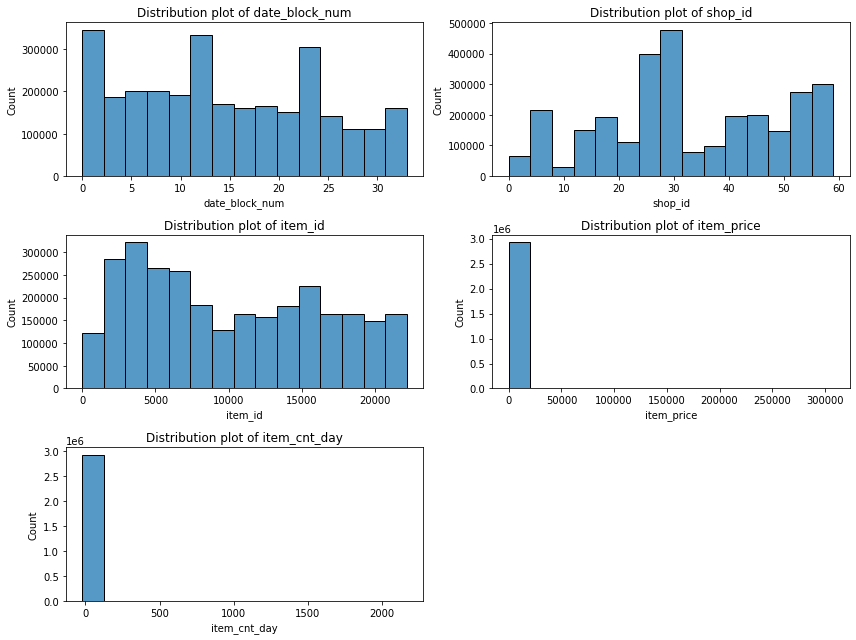

In [19]:
#plotando o histograma das variaveis numéricas
plt.figure(figsize=(12,9))
for i in range(len(lista)):
  plt.subplot(3,2,i+1)
  sns.histplot(x=lista[i], bins=15,data=df_sales_train)
  plt.title('Distribution plot of {}'.format(lista[i]))
  plt.tight_layout()

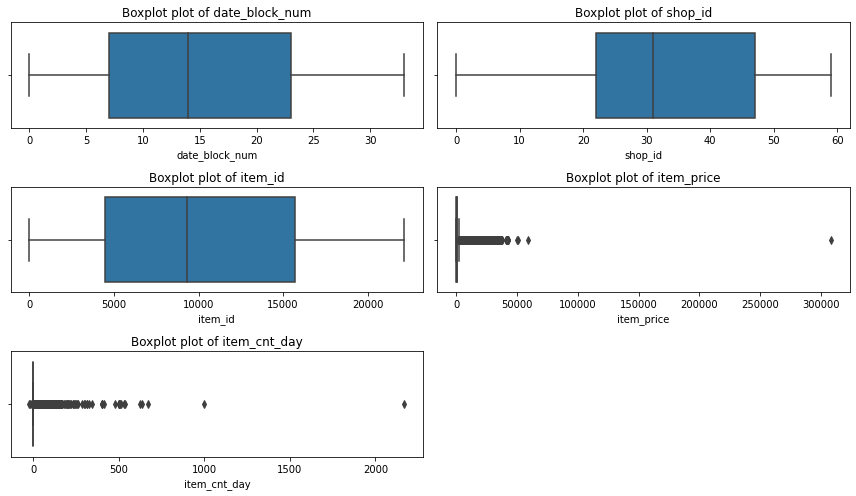

In [20]:
# Plotando o box plot dos dados numéricos
plt.figure(figsize=(12,7))
for i in range(len(lista)):
  plt.subplot(3,2,i+1)
  sns.boxplot(df_sales_train[lista[i]])
  plt.title('Boxplot plot of {}'.format(lista[i]))
  plt.tight_layout()

Os dados do histograma acima mostram a distribuição dos dados. Os pontos importantes, é que a variavel shop_id correspondentes as lojas, mostrou que temos mais frequencia da loja 31. Já as variaveis Item_price e item_cnt_day indicaram pontos de outliers, como mostra os box-plot abaixo. Não, vamos fazer o tratamento de outliers ainda , por que esse ainda não é o dataset final que irá ser trabalhado para o modelo.

In [21]:
figura = pd.DataFrame(df_sales_train.groupby('date')['item_cnt_day'].sum()).reset_index()
plot_line(figura,'date','item_cnt_day', 'Quantidade de vendas dos Produtos por dia') #visualizando com o plotly

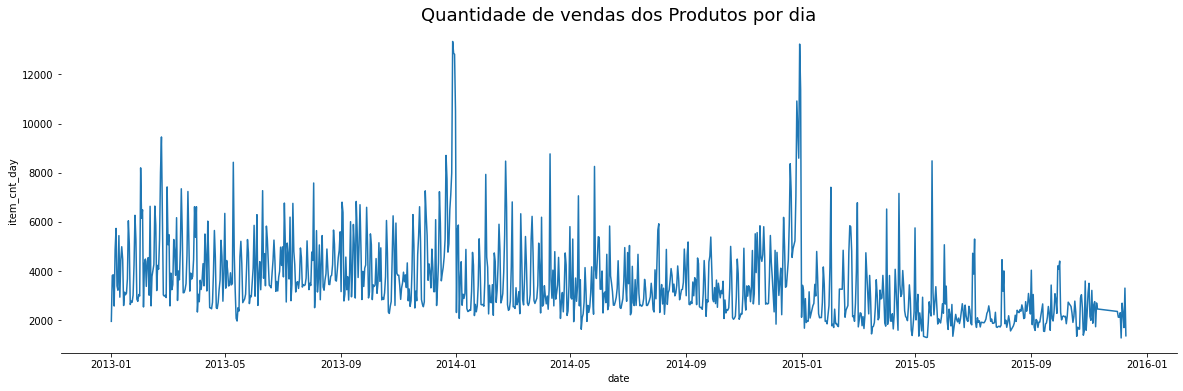

In [22]:
plot_line2(figura,'date','item_cnt_day', 'Quantidade de vendas dos Produtos por dia')

O gráfico nos mostra uma leve tendencia de queda com o passar do tempo, principalmente a partir de 2015.

## 3.1 Visualizando os dados por Produto

In [23]:
#Filtrando o produto por quantindade de vendas para melhor visualização
item_top10 = pd.DataFrame(df_sales_train.groupby('item_id')['item_cnt_day'].sum()\
                        .rename({'item_cnt_day': 'quantidade'}, axis='columns'))\
                        .sort_values(by = ['item_cnt_day'], ascending = False )\
                            .reset_index().head(10)

In [24]:
#para uma melhor visulização grafica
item_top10['item_id'] = item_top10['item_id'].astype(str)

In [25]:
# visualizando com o plotly
fig = px.bar(item_top10, x='item_id', y='item_cnt_day', template= 'simple_white',
 text = 'item_cnt_day', color_discrete_sequence=px.colors.qualitative.T10 )
fig.update_xaxes(zeroline = True, zerolinewidth =2)
fig.update_traces(textposition="outside", texttemplate='%{text:.3s}')
fig.update_xaxes(zeroline = True, zerolinewidth =2, title = 'Item_id' )
fig.update_yaxes(showticklabels = False, title= '' , showline = False, ticks = '')
fig.update_layout(title={'text': 'Os produtos mais vendidos', 'y': 0.98, 'x': 0.5})
fig.show()

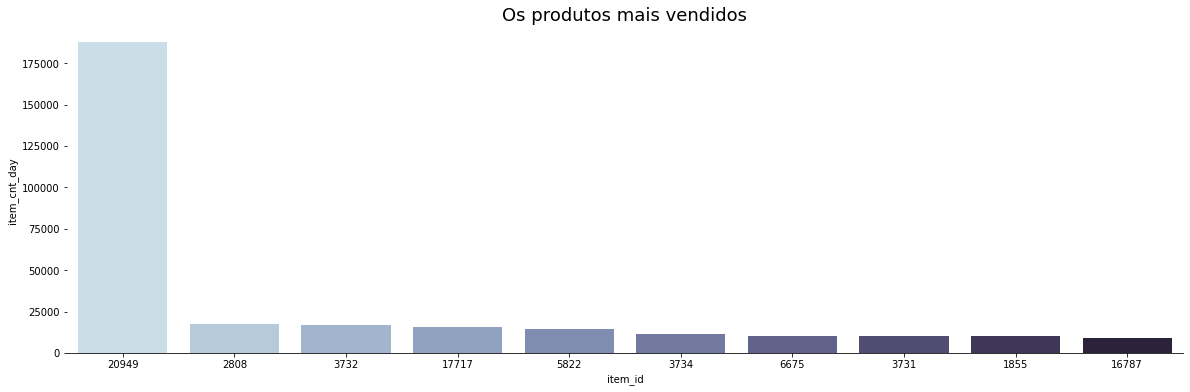

In [26]:
plt.figure(figsize=(20,6))
plt.title('Os produtos mais vendidos', fontsize = 18)
sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)
sns.barplot(x="item_id", y="item_cnt_day", data=item_top10, palette= "ch:s=.25,rot=-.25")
sns.despine(left=True)

No gráfico acima mostra o top 10 de produtos por quantidade de vendas. Por isso, o produto escolhido para análise vai ser o **20949** que apresenta uma saida de produtos perto dos 188k.

A partir disso, vamos filtrar no nossa base o produto escolhido e continuar a análise dos dados.

In [27]:
#Filtrando o produto 20949 na base de dados

Item_20949 = df_sales_train[df_sales_train['item_id'] == 20949].reset_index(drop= True)

In [28]:
Item_20949.head(1)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-05,4,53,20949,5.0,8.0


Com isso, vamos fazer a visualização dos dados do produto escolhido.

In [29]:
figura = pd.DataFrame(Item_20949.groupby('date_block_num')['item_cnt_day'].sum()).reset_index()
plot_line(figura,'date_block_num','item_cnt_day', 'Quantidade de vendas do Produto 20949 por mês')

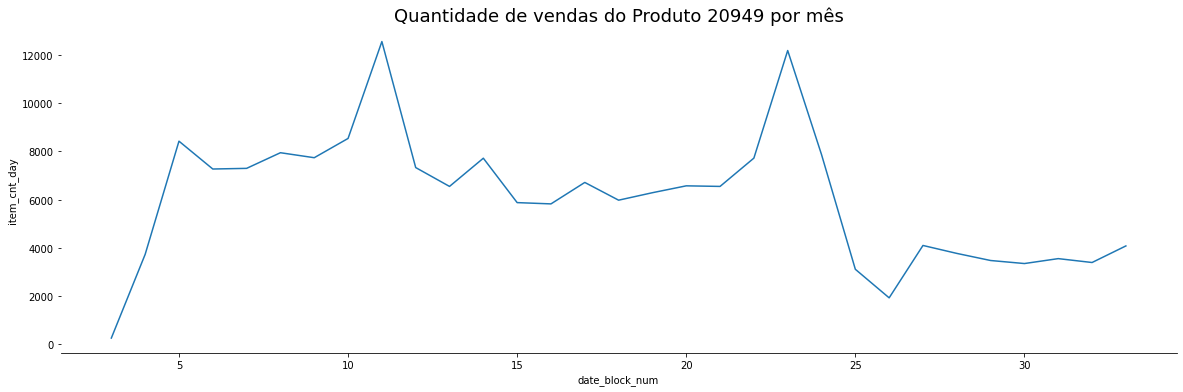

In [30]:
plot_line2(figura,'date_block_num','item_cnt_day', 'Quantidade de vendas do Produto 20949 por mês')

In [31]:
figura = pd.DataFrame(Item_20949.groupby('date')['item_cnt_day'].sum()).reset_index()
plot_line(figura,'date','item_cnt_day', 'Quantidade de vendas do Produto 20949 por dia')

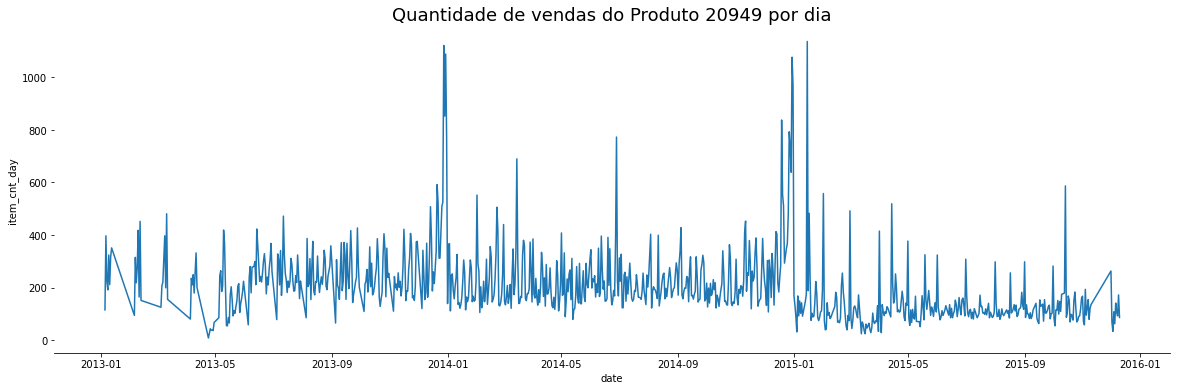

In [32]:
plot_line2(figura,'date','item_cnt_day', 'Quantidade de vendas do Produto 20949 por dia')

Os dos gráfico acima, mostram picos de vendas em janeiro de 2014 e 2015 e uma leve tendencia de queda na quantidade de vendas a partir de 2015.

## 3.2 Visualizando os dados por loja

Agora, vamos escolher a loja que vai ser utilizada para análise de forecasting

In [33]:
loja_top10 = pd.DataFrame(Item_20949.groupby('shop_id')['item_cnt_day'].sum()\
    .rename({'item_cnt_day': 'quantidade'}, axis='columns'))\
    .sort_values(by='item_cnt_day', ascending=False)\
    .reset_index().head(10)
loja_top10

,shop_id,item_cnt_day
0,31,19934.0
1,25,14343.0
2,28,13458.0
3,54,12323.0
4,42,10514.0
5,27,8265.0
6,57,6116.0
7,47,4530.0
8,22,4382.0
9,21,4335.0


In [34]:
#para uma melhor visulização grafica
loja_top10['shop_id'] = loja_top10['shop_id'].astype(str)

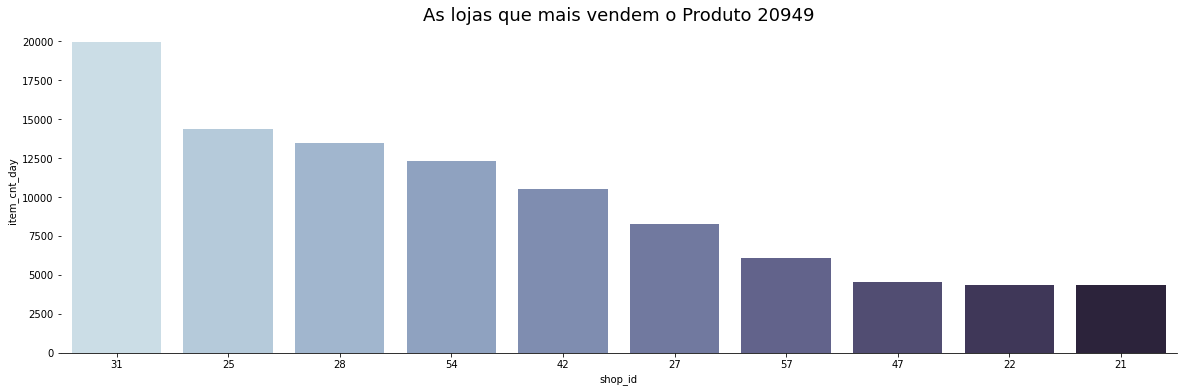

In [35]:
plt.figure(figsize=(20,6))
plt.title('As lojas que mais vendem o Produto 20949', fontsize = 18)
sns.barplot(x="shop_id", y="item_cnt_day", data=loja_top10, palette= "ch:s=.25,rot=-.25")
sns.despine(left=True)

In [36]:
#visualizando com o plotly
fig = px.bar(loja_top10, x='shop_id', y='item_cnt_day', template= 'simple_white',
 text = 'item_cnt_day', color_discrete_sequence=px.colors.qualitative.T10 )
fig.update_xaxes(zeroline = True, zerolinewidth =2)
fig.update_traces(textposition="outside", texttemplate='%{text:.3s}')
fig.update_xaxes(zeroline = True, zerolinewidth =2, title = 'Item_shop' )
fig.update_yaxes(showticklabels = False, title= '' , showline = False, ticks = '')
fig.update_layout(title={'text': 'As lojas que mais vendem o Produto 20949', 'y': 0.98, 'x': 0.5})
fig.show()

A Loja 31 é que apresenta a maior quantidade desse produto em vendas. Então, é por esse motivo que vai ser a loja escolhida para a nossa análise.

## 3.2 Visualização da loja 31 pelo produto 20949

Agora já escolhemos qual o produto e loja que vamos utilizar para análise. Com isso, vamos fazer mais algumas visualização dos dados, para um melhor entedimento da base final.

In [37]:
# Filtrando a loja da 31 no dataset
df_shop31_Item_20949= Item_20949[Item_20949['shop_id'] == 31].reset_index(drop = True)

In [38]:
df_shop31_Item_20949.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-05,4,31,20949,5.0,1.0
1,2013-01-06,5,31,20949,5.0,29.0
2,2013-01-07,6,31,20949,5.0,29.0
3,2013-01-08,7,31,20949,5.0,22.0
4,2013-01-09,8,31,20949,5.0,41.0


In [39]:
#visualizando o tamnho do dateset final
df_shop31_Item_20949.shape

(863, 6)

### 3.2.1 Análise Descritiva dos Dados

A variavel alvo a ser estudada aqui na análise é <item_cnt_day>, na nos mostra a quantidade de vendas dos produtos, por isso vamos plotar os gráficos agora em função dela.

In [40]:
#histograma como plotly
fig = px.histogram(df_shop31_Item_20949, x='item_cnt_day', template= 'simple_white')
fig.update_layout(title={'text': 'Distribuição da variavel "item_cnt_day"', 'y': 0.98, 'x': 0.5})
fig.update_xaxes(title = 'Quantidade_produto')
fig.update_yaxes(title= 'Frequência')
fig.show()

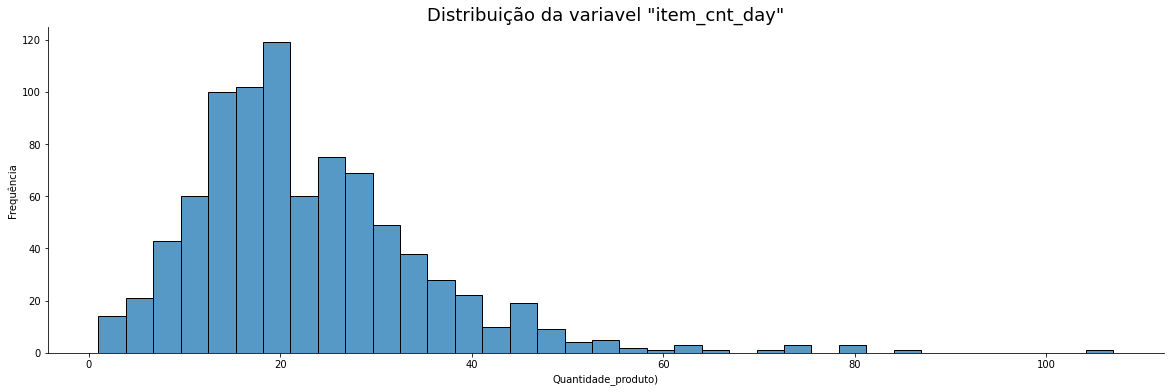

In [41]:
plt.figure(figsize=(20,6))
sns.histplot(df_shop31_Item_20949['item_cnt_day'])
plt.title('Distribuição da variavel "item_cnt_day"', fontsize = 18)
plt.ylabel('Frequência')
plt.xlabel('Quantidade_produto)')
sns.despine()

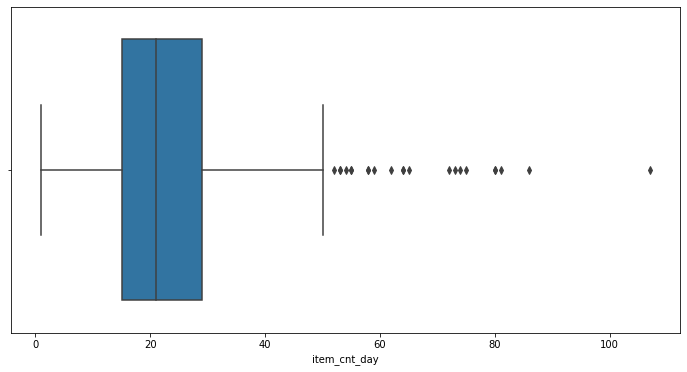

In [42]:
plt.figure(figsize=(12,6))
sns.boxplot(df_shop31_Item_20949['item_cnt_day'])

Como podemos observar no histograma que apreesenta um distribuição assimétrica a direita, com alguns outliers de qunatidades de vendas a partir de 60 em concordância com o gráfico de box-plot abaixo que nos mostra que 50% da qunatidade dos produtos está um pouco acima de 20.

In [43]:
#visualizando com o plotly
plot_line(df_shop31_Item_20949,'date','item_cnt_day', 'Quantidade de vendas do Produto 20949 por dia')

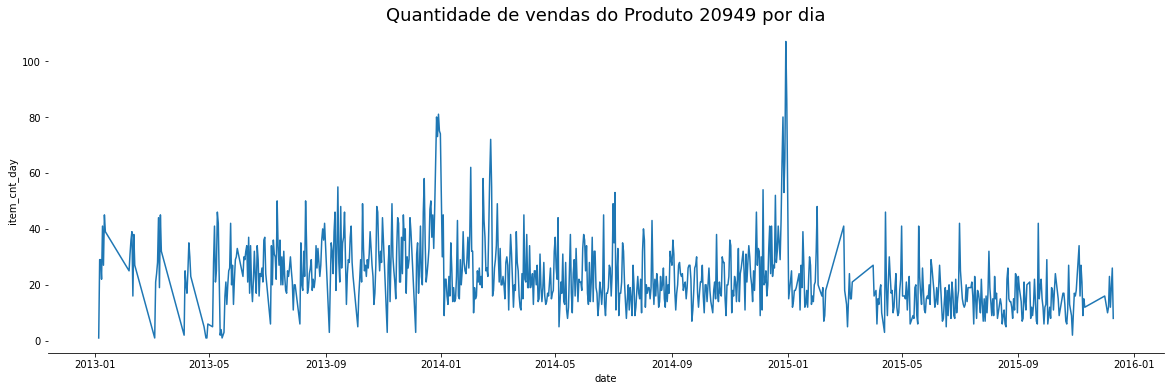

In [44]:
plot_line2(df_shop31_Item_20949,'date','item_cnt_day', 'Quantidade de vendas do Produto 20949 por dia')

In [45]:
df_mensal = df_shop31_Item_20949.copy() #fazendo uma cópia do dataset
df_mensal.set_index('date', inplace = True) #transformando a coluna data em index
df_mensal = df_mensal.resample(rule = 'M').last() #reordenando o dataset por mês

In [46]:
#visualizando com o plotly
plot_line(df_mensal,df_mensal.index,'item_cnt_day', 'Quantidade de vendas do Produto 20949 por mês')

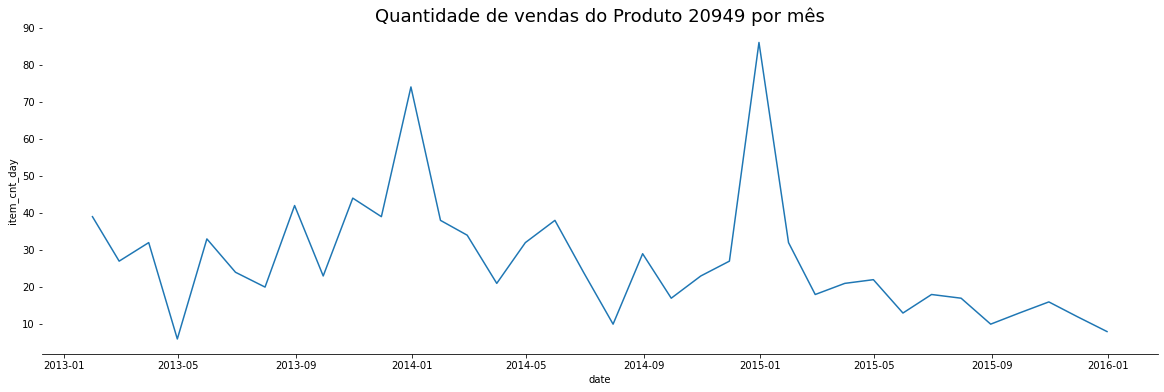

In [47]:
plot_line2(df_mensal,df_mensal.index,'item_cnt_day', 'Quantidade de vendas do Produto 20949 por mês')

Como podemos observar o produto estudado aqui, tem um saida maior no começo dos anos. Apresenta picos em janeiro de 2014 e em janeiro de 2015.

In [48]:
#visualizando com o plotly
df_mensal['sales_month'] = df_mensal['item_price'] * df_mensal['item_cnt_day']
plot_line(df_mensal,df_mensal.index,'sales_month', ' Vendas do Produto 20949 por mês')

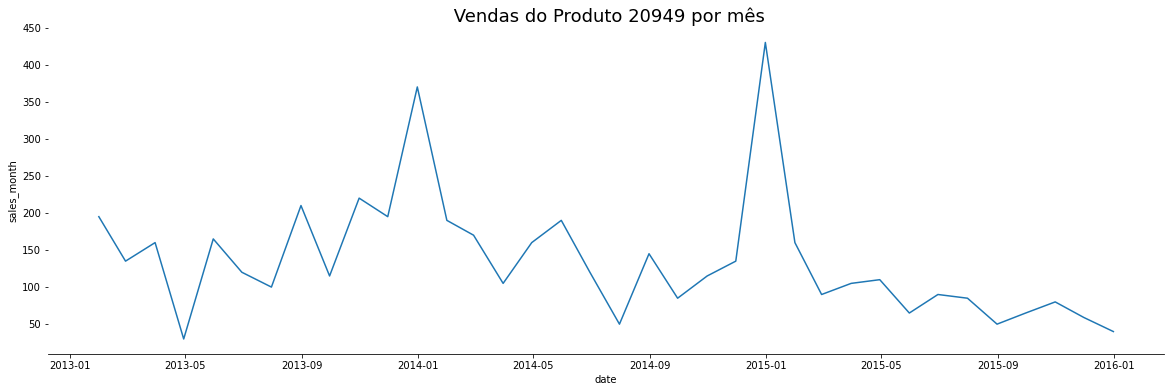

In [49]:
plot_line2(df_mensal,df_mensal.index,'sales_month', ' Vendas do Produto 20949 por mês')

### 3.2.1 Análise de Correlação

Vamos fazer uma análise de correlação da variavel target em função do tempo para analisar o comportamento.

Text(0.5, 1.0, 'Correlação da quantidade do produto pelo tempo ')

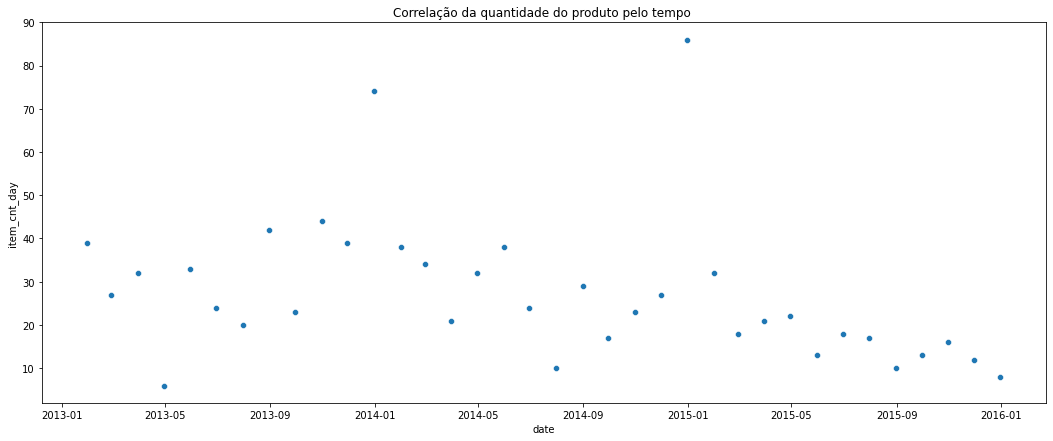

In [50]:
plt.figure(figsize=(18,7))

sns.scatterplot(x=df_mensal.index,y='item_cnt_day',data=df_mensal)
plt.title('Correlação da quantidade do produto pelo tempo ')

A série não apresenta uma correlação alta com o tempo.

# 4. Análise Da Série Temporal 'item_cnt_day'

A partir daqui vamos analisar o comportamento da nossa variavel target, mediante conceitos de séries temporais.

## 4.1 Decomposição dos dados

Vamos decompor os dados em tendencia, sazonalidade e residuos, porque toda série temporal pode ser decomposta nessas trÊs partes.

In [51]:
#função de sazonalidade
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()

In [52]:
df_shop31_Item_20949.set_index('date', inplace = True) #transformando a coluna data em index

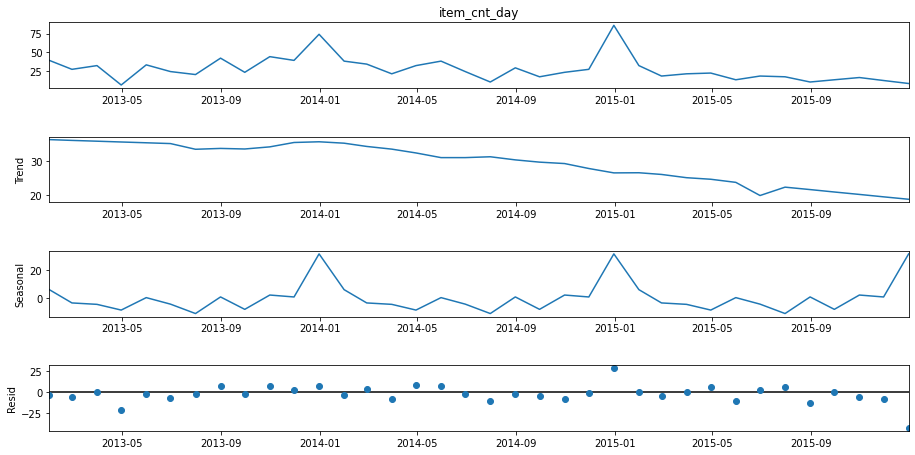

In [53]:
seasonal_decompose (df_mensal['item_cnt_day'])

Claramente a série apresenta uma tendência de baixa a partir de maio de 2014. Apresentando também picos no começo de cada ano, indicando alguma sazonalidade.

## 4.2 Autocorrelação e Autocorrelação Parcial

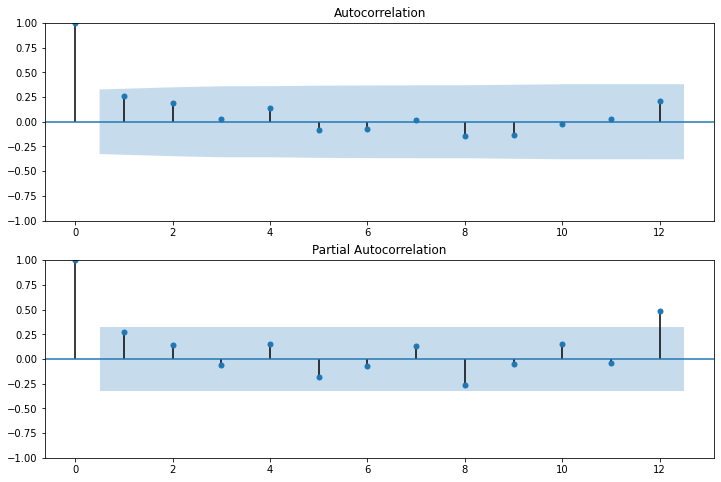

In [54]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_mensal['item_cnt_day'].values.squeeze(), lags=12, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_mensal['item_cnt_day'], lags=12, ax=ax2)

Aqui estamos analisando se a série possue alguma correlação com ela mesmo, mas quase nenhum lag tem efeito sobre o periodo atual.Então, vamos seguir:

## 4.3 Estacionariedade da Série

Aqui vamos checar a estacionariedade da série, verificando o comportamento da média ao longo do tempo.

In [55]:
# Definido algumas funções para o teste de estacionariedade
def test_stationarity(timeseries, title):
    
    #Determiando a janela
    rolmean = pd.Series(timeseries).rolling(window=4).mean() 
    rolstd = pd.Series(timeseries).rolling(window=4).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()

# Teste de Dick fuller
def ADF_test(timeseries, dataDesc):
    print(f' > A série {dataDesc} é estacionária ?')
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print(f'Test statistic = {dftest[0]:.3f}')
    print(f'P-value = {dftest[1]:.3f}')
    print('Critical values :')
    for k, v in dftest[4].items():
        print(f'\t{k}: {v} - A base é {"não" if v < dftest[0] else ""} estacionária com {100-int(k[:-1])}% confiança')

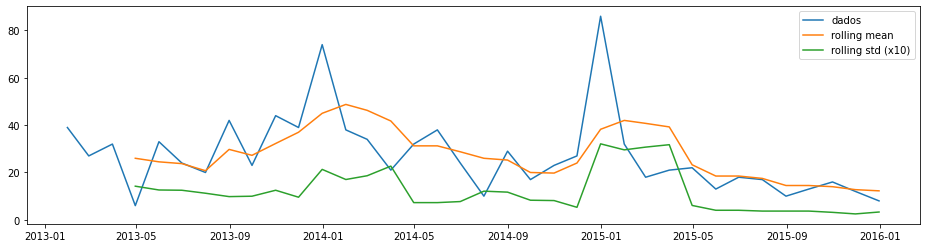

In [56]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(df_mensal['item_cnt_day'], 'dados')

Como podemos verificar a média apresenta dois picos ali, como já comentados em outras análises.

In [57]:
# Aplicando o teste de Dick fuller na série temporal
ADF_test(df_mensal['item_cnt_day'],'quantidade_produto')

 > A série quantidade_produto é estacionária ?
Test statistic = -4.274
P-value = 0.000
Critical values :
	1%: -3.6327426647230316 - A base é  estacionária com 99% confiança
	5%: -2.9485102040816327 - A base é  estacionária com 95% confiança
	10%: -2.6130173469387756 - A base é  estacionária com 90% confiança


O teste de dick fuller, nos mostrou que a série é estacionária com uma confiança de 90%,95% e 99%, mesmo mostrando aqueles picos vistos na sazonalidade e aquela pequena tendencia de queda.

## 4.3.1 Fazendo a diferenciação (DIFF)

O método diff nada mais é que tentar tirar a sazonalidade da série, para o modelo de série temporal ter uma melhor captura do comportamento da série analisada aqui. Nesse caso, vamo tirar a diferença de 1 mês.

In [58]:
# definindo a função para determinar o diff
def get_diff(data):
    data['item_cnt_day_diff'] = data.item_cnt_day.diff()    
    data = data.dropna()      
    return data
stationary_df = get_diff(df_mensal)

In [59]:
plot_line(stationary_df, stationary_df.index, 'item_cnt_day_diff', 'Quantidades de vendas depois do Diff After Diff Transformation')

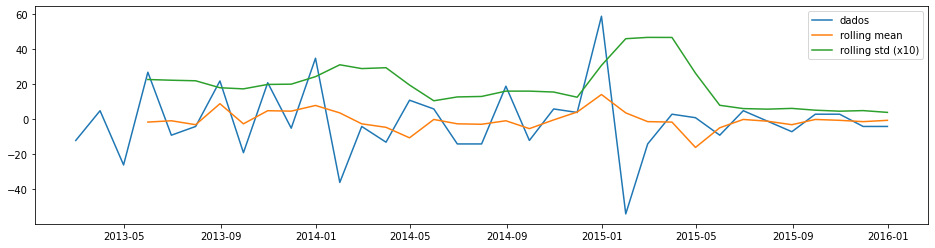

In [60]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(stationary_df['item_cnt_day_diff'], 'dados')

In [61]:
# Aplicando o teste de Dick fuller na série temporal
ADF_test(stationary_df['item_cnt_day'],'item_cnt_day_diff')

 > A série item_cnt_day_diff é estacionária ?
Test statistic = -4.160
P-value = 0.001
Critical values :
	1%: -3.639224104416853 - A base é  estacionária com 99% confiança
	5%: -2.9512301791166293 - A base é  estacionária com 95% confiança
	10%: -2.614446989619377 - A base é  estacionária com 90% confiança


A nossa série continua sendo estacionária, mas veja que conseguimos deixar a média (Figura acima) um pouco melhor para o modelo. Por isso, a modelagem vai ser feita na minha variavel com diferenciação.

# 5. Engenharia de Features

Vamos criar algumas features para tentar melhorar a previsão do modelo

In [62]:
stationary_df['mes'] = [i.month for i in stationary_df.index] #add uma coluna de mês
stationary_df['ano'] = [i.year for i in stationary_df.index] #add uma couna de ano


In [63]:
stationary_df.head(1)

,date_block_num,shop_id,item_id,item_price,item_cnt_day,sales_month,item_cnt_day_diff,mes,ano
date,,,,,,,,,
2013-02-28,11,31,20949,5.00000000,27.00000000,135.00000000,-12.00000000,2,2013


# 6. Separação da Base de Treino e Teste

In [64]:
x=stationary_df.drop(columns =['item_cnt_day', 'sales_month', 'shop_id', 'item_id', 'date_block_num', 'item_price', 'item_cnt_day_diff'])
y=stationary_df.item_cnt_day_diff

In [65]:
x = sm.add_constant(x) #adicionando uma constante base da variavel regressoras ou exogenas.

In [66]:
x.head()

,const,mes,ano
date,,,
2013-02-28,1.00000000,2,2013
2013-03-31,1.00000000,3,2013
2013-04-30,1.00000000,4,2013
2013-05-31,1.00000000,5,2013
2013-06-30,1.00000000,6,2013


In [67]:
## Função para a separação da base de teste e treino do modelo
def train_test_split(x,y,date_train_star,date_train_end,date_test_star):
  y_train=y.loc[date_train_star:date_train_end]
  x_train =x.loc[date_train_star:date_train_end]
  y_test=y.loc[date_test_star:]
  x_test=x.loc[date_test_star:]
  return x_train, x_test, y_train, y_test

Respeitando o conceito de séries temporais, a base de teste do meu dataset vai ser os últimos 5 meses dos dados e base de treino será o restante.

In [68]:
x_train, x_test, y_train, y_test = train_test_split(x,y, '2013-01-31','2015-07-31', '2015-08-31')

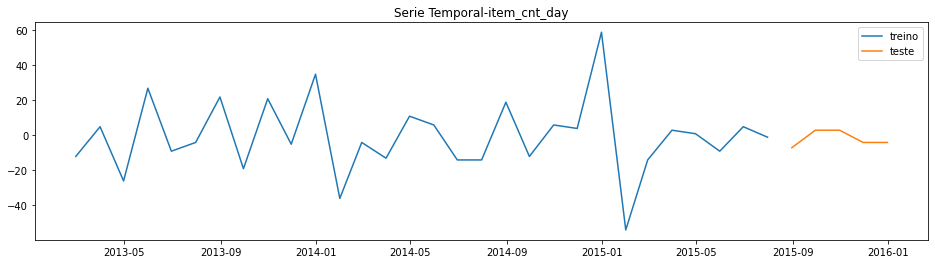

In [69]:
##Visualização da separação da base de treino e teste
plt.figure(figsize=(16,4))
plt.plot(y_train, label= 'treino')
plt.plot(y_test, label= 'teste')
plt.title('Serie Temporal-item_cnt_day')
plt.legend(loc = 'Left corner')
plt.show()

#7. Escalonando as variaveis

In [70]:
# Normalização das variáveis

scaler = MinMaxScaler()
scaler.fit(x_train)

X_train_scaled = scaler.transform(x_train)
X_test_scaled = scaler.transform(x_test)
X_escalo = scaler.transform(x)
# Transformand para dataframe para visualização
x_train = pd.DataFrame(X_train_scaled,columns = x_train.columns, index =x_train.index )
x_test = pd.DataFrame(X_test_scaled,columns = x_train.columns, index = x_test.index)
x = pd.DataFrame(X_escalo,columns = x.columns, index = x.index)

# 8. Modelando a Série Temporal

Para a modelagem da série temporal, foi escohido dois tipos de modelos o ARIMA e a sua derivação o SARIMAX. São modelos estatísticos muito autlizados para esse tipo de abordagem.

## 8.1 Modelando com o Auto-arima

O auto arima irá ser utlizado para encontrar a melhor configuração do seus parametros para essa base de dados.

In [71]:
stepwise =  auto_arima(y,
                    start_p=0,
                    start_q=0,
                    max_order=4,
                    m = 12,
                    seasonal=True,
                    trace=True,
                    test= 'adf',
                    error_action='warn',
                    suppress_warnings=True,
                    stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=311.949, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=303.236, Time=0.11 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=297.175, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=310.020, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=298.277, Time=0.13 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=307.447, Time=0.12 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,0,2)(0,0,1)[12] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=302.588, Time=0.13 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=inf, Time=0.47 sec

In [72]:
  ##Treinamento do modelo com os melhores valores de AIC e BIC
stepwise.fit(y_train)
previsao = stepwise.predict(n_periods=5)
print(stepwise.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   30
Model:             SARIMAX(0, 0, 1)x(0, 0, 1, 12)   Log Likelihood                -123.947
Date:                            Fri, 02 Sep 2022   AIC                            253.894
Time:                                    03:21:05   BIC                            258.097
Sample:                                02-28-2013   HQIC                           255.239
                                     - 07-31-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8671      0.145     -5.984      0.000      -1.151      -0.583
ma.S.L12       0.9973    137.550   

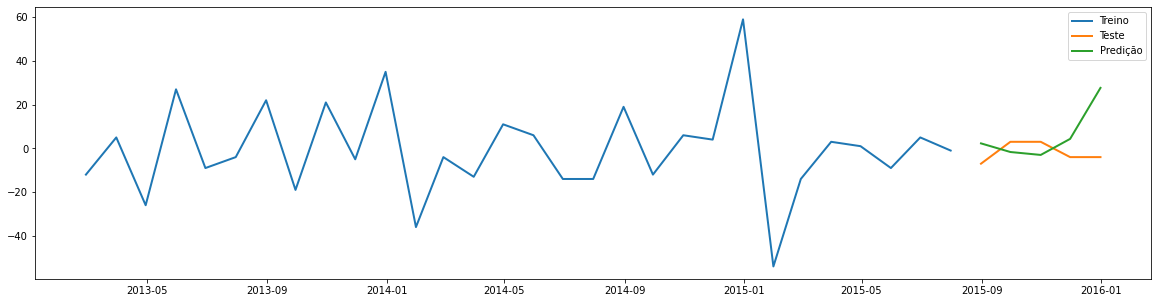

In [73]:
  ##Previsão de 6 meses do modelo arima, com os melhores coeficientes dados no auto-arima
  previsao = pd.DataFrame(previsao,index=y_test.index, columns=['previsão modelo 1'])
  plt.figure(figsize=(20,5))
  plt.plot(y_train, label = 'Treino', linewidth=2)
  plt.plot(y_test, label = 'Teste', linewidth=2)
  plt.plot(previsao, label = 'Predição', linewidth=2)
  plt.legend(loc = 'Left corner')
  plt.show()

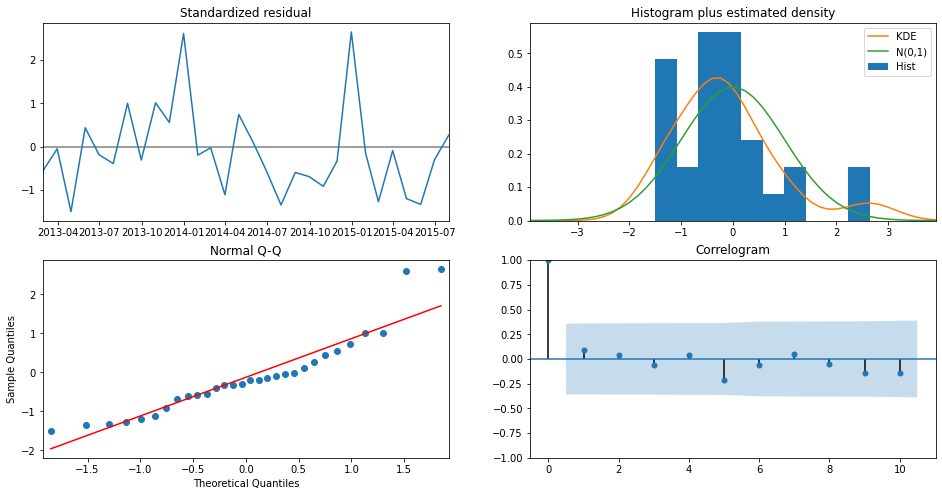

In [74]:
  ##Plot do gráfico de diagnóstico do modelo
  stepwise.plot_diagnostics(figsize=(16, 8))
  plt.show()

In [75]:
d = {'metricas': ['RMSE', 'MAE'], 
       'base_teste': [mean_squared_error(y_test, previsao, squared= False),
                      mean_absolute_error(y_test, previsao),
                      ] }
tabel_metrics = pd.DataFrame(data = d)
print('='*10,'TABELA DE MÉTRICAS','='*10)
print(tabel_metrics)

========== TABELA DE MÉTRICAS ==========
  metricas  base_teste
0     RMSE 15.59552170
1      MAE 11.98920729


## 8.2 Modelando com o Sarimax

Os parametros no Sarimax , foram definidos com o auto-arima.

                                     SARIMAX Results                                      
Dep. Variable:                  item_cnt_day_diff   No. Observations:                   30
Model:             SARIMAX(0, 0, 1)x(0, 0, 1, 12)   Log Likelihood                -123.947
Date:                            Fri, 02 Sep 2022   AIC                            253.894
Time:                                    03:21:06   BIC                            258.097
Sample:                                02-28-2013   HQIC                           255.239
                                     - 07-31-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8671      0.145     -5.984      0.000      -1.151      -0.583
ma.S.L12       0.9973    137.550   

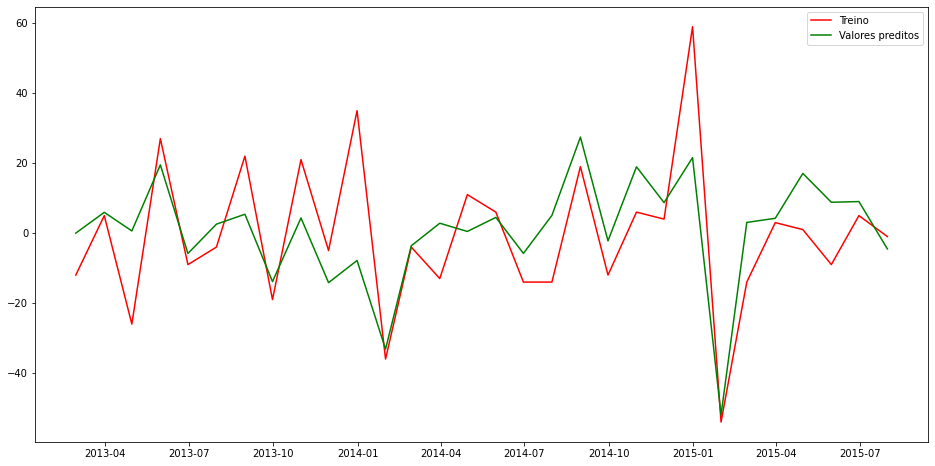

In [76]:
  mod = SARIMAX(y_train, order=(0,0,1), seasonal_order=(0, 0, 1, 12))
  fit_res = mod.fit(disp=False, maxiter=250)
  print(fit_res.summary())

  predito = fit_res.predict(typ='levels')

  ## Plot da previsão da base de treino
  plt.figure(figsize=(16,8))
  plt.plot(y_train, color='red')
  plt.plot(predito,color='green')
  plt.legend(['Treino','Valores preditos'])
  plt.show()

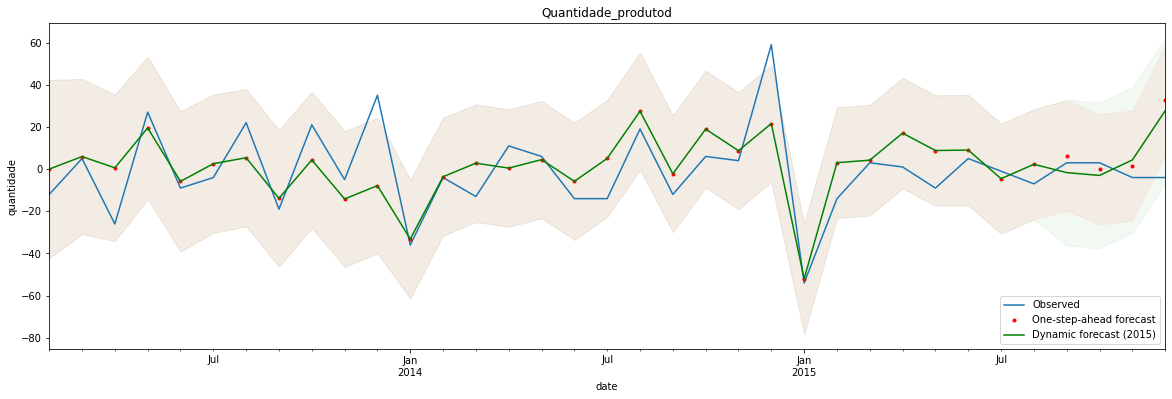

In [77]:
  ## Treinando o modelo com todos os dados para a previsão
  mod = sm.tsa.statespace.SARIMAX(y, order=(0,0,1), seasonal_order=(0, 0, 1, 12))
  res = mod.filter(fit_res.params)

  predict = res.get_prediction()
  predict_ci = predict.conf_int()

  # Predições dinâmicas
  predict_dy = res.get_prediction(dynamic = '2015-08-31' )
  predict_dy_ci = predict_dy.conf_int()

  # Gráficos
  fig, ax = plt.subplots(figsize=(20,6))
  npre = 4
  ax.set(title='Quantidade_produtod', xlabel='Date', ylabel='quantidade')

  # Plot da variavel target
  y.plot(ax=ax, style='-', label='Observed')

  # Plot das predições
  predict.predicted_mean.plot(ax=ax, style='r.', label='One-step-ahead forecast')
  ci = predict_ci
  ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.05)
  predict_dy.predicted_mean.plot(ax=ax, style='g', label='Dynamic forecast (2015)')
  ci = predict_dy_ci
  ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='g', alpha=0.05)

  legend = ax.legend(loc='lower right')
  plt.show()

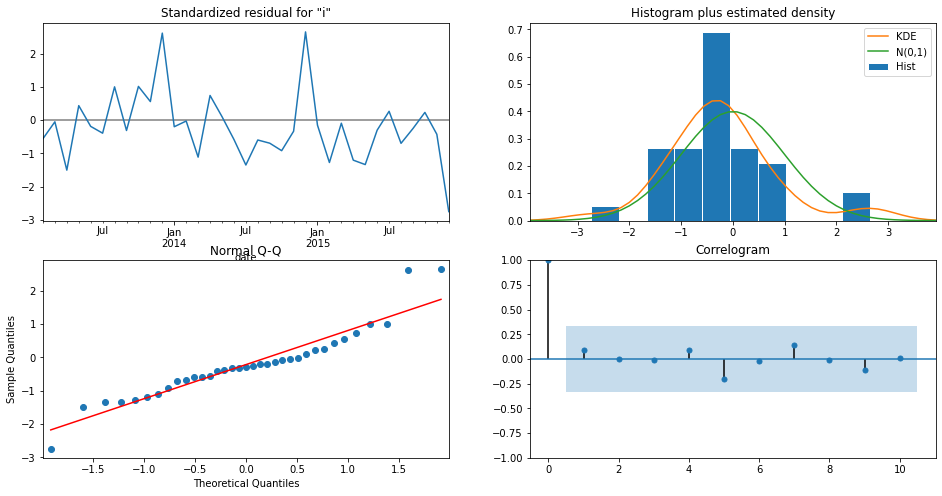

In [78]:
  ##Plot do disgnóstico dos residuos
  res.plot_diagnostics(figsize=(16, 8))
  plt.show()

In [79]:
  d = {'metricas': ['RMSE','MAE'], 
       'base_treino': [mean_squared_error(y_train, predito, squared= False),
                       mean_absolute_error(y_train, predito),
                       ],
       'base_teste': [mean_squared_error(y_test, predict_dy.predicted_mean.loc['2015-08-31':], squared= False), 
                      mean_absolute_error(y_test, predict_dy.predicted_mean.loc['2015-08-31':]),
                      ] }
  tabel_metrics = pd.DataFrame(data = d)
  print('='*10,'TABELA DE MÉTRICAS','='*10)
  print(tabel_metrics)

========== TABELA DE MÉTRICAS ==========
  metricas  base_treino  base_teste
0     RMSE  15.18844045 15.59552170
1      MAE  11.35271531 11.98920729


O Sarimax apresentou resultados melhores quando comparado com o auto-arima.

## 8.2.1 Agregando variaveis exogenas ao modelo

                                     SARIMAX Results                                      
Dep. Variable:                  item_cnt_day_diff   No. Observations:                   30
Model:             SARIMAX(0, 0, 1)x(0, 0, 1, 12)   Log Likelihood                -120.671
Date:                            Fri, 02 Sep 2022   AIC                            253.341
Time:                                    03:21:08   BIC                            261.749
Sample:                                02-28-2013   HQIC                           256.031
                                     - 07-31-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const               0         -0        nan        nan           0           0
mes            1.8019      1.205   

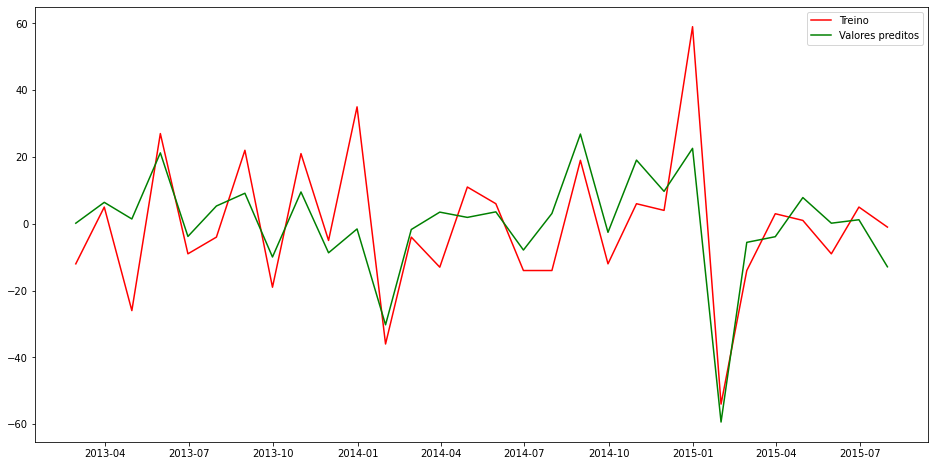

In [80]:
  mod = SARIMAX(y_train,exog=x_train, order=(0,0,1), seasonal_order=(0, 0, 1, 12))
  fit_res = mod.fit(disp=False, maxiter=250)
  print(fit_res.summary())

  predito = fit_res.predict(typ='levels')

  ## Plot da previsão da base de treino
  plt.figure(figsize=(16,8))
  plt.plot(y_train, color='red')
  plt.plot(predito,color='green')
  plt.legend(['Treino','Valores preditos'])
  plt.show()

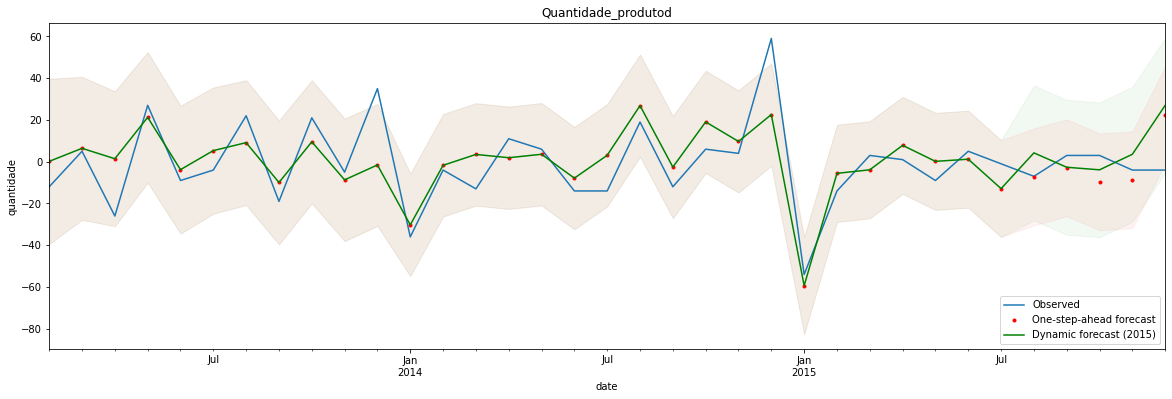

In [81]:
  ## Treinando o modelo com todos os dados para a previsão
  mod = sm.tsa.statespace.SARIMAX(y,exog = x, order=(0,0,1), seasonal_order=(0, 0, 1, 12))
  res = mod.filter(fit_res.params)

  predict = res.get_prediction()
  predict_ci = predict.conf_int()

  # Predições dinâmicas
  predict_dy = res.get_prediction(dynamic = '2015-07-31' )
  predict_dy_ci = predict_dy.conf_int()

  # Gráficos
  fig, ax = plt.subplots(figsize=(20,6))
  npre = 4
  ax.set(title='Quantidade_produtod', xlabel='Date', ylabel='quantidade')

  # Plot da variavel target
  y.plot(ax=ax, style='-', label='Observed')

  # Plot das predições
  predict.predicted_mean.plot(ax=ax, style='r.', label='One-step-ahead forecast')
  ci = predict_ci
  ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.05)
  predict_dy.predicted_mean.plot(ax=ax, style='g', label='Dynamic forecast (2015)')
  ci = predict_dy_ci
  ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='g', alpha=0.05)

  legend = ax.legend(loc='lower right')
  plt.show()

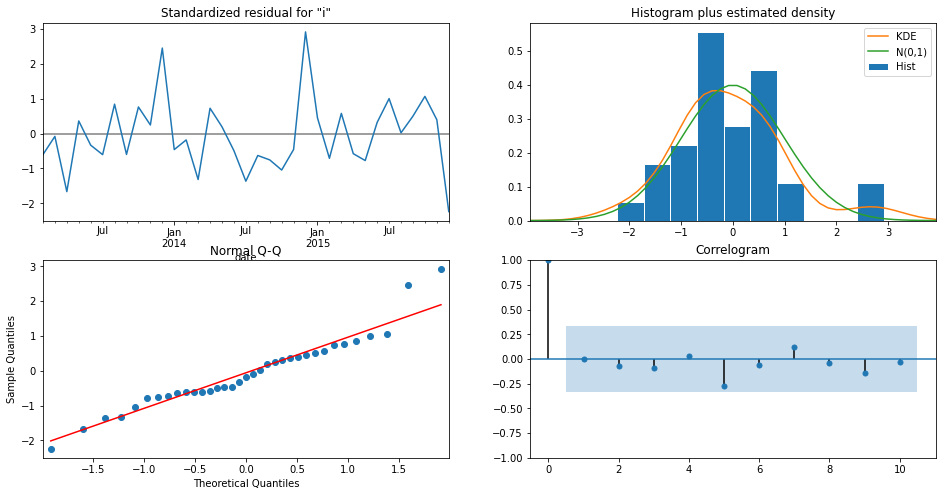

In [82]:
  ##Plot do disgnóstico dos residuos
  res.plot_diagnostics(figsize=(16, 8))
  plt.show()

In [83]:
  d = {'metricas': ['RMSE', 'MAE'],  
       'base_treino': [mean_squared_error(y_train, predito, squared= False), 
                       mean_absolute_error(y_train, predito)],
       'base_teste': [mean_squared_error(y_test, predict_dy.predicted_mean.loc['2015-08-31':], squared= False), 
                      mean_absolute_error(y_test, predict_dy.predicted_mean.loc['2015-08-31':])] }
  tabel_metrics = pd.DataFrame(data = d)
  print('='*10,'TABELA DE MÉTRICAS','='*10)
  print(tabel_metrics)

========== TABELA DE MÉTRICAS ==========
  metricas  base_treino  base_teste
0     RMSE  13.68781785 15.64507343
1      MAE  10.63429979 12.46710683


Aqui percebemos que as métricas do SARIMAX com as variaveis exógenas foram melhores, juntamente com a análise de resíduo.

### 8.2.2 Usando o cros validation

Vamos utilizar um cross-validation para verificar o comportamento da nossa métrica ao longo da série, com uma janela de tempo de 5 meses, ao longo da série.

In [84]:
rmse_treino =[]
rmse_teste = []

mae_treino =[]
mae_test = []
cont = 0
for i in range(5, df_mensal.shape[0] - 4):
  cont += 1
  x_train =x.iloc[:i]
  x_test = x.iloc[x_train.shape[0]:x_train.shape[0]+5]
  y_train =y.iloc[:i]
  y_test = y.iloc[x_train.shape[0]:x_train.shape[0]+5]
  x_t = x.iloc[:x_train.shape[0]+5]
  y_t= y.iloc[:x_train.shape[0]+5]
    

  modelo3 = SARIMAX(y_train, exog = x_train, order=(3,0,0), seasonal_order=(1, 0, [1, 2], 12), enforce_stationarity=False)
  
  fit_res = modelo3.fit(disp=False, maxiter=250)
  predito = fit_res.predict(typ='levels')
  rmse_treino.append(np.sqrt(mean_squared_error(y_train, predito)))
  mae_treino.append(mean_absolute_error(y_train, predito))

  modelo3 = SARIMAX(y_t, exog = x_t, order=(3,0,0), seasonal_order=(1, 0, [1, 2], 12),enforce_stationarity=False )

  res1 = modelo3.filter(fit_res.params)

  predict = res1.get_prediction()
  predict_ci = predict.conf_int()

  
  # Predições dinâmicas
  predict_dy = res1.get_prediction(dynamic= y_test.index[0])
  predict_dy_ci = predict_dy.conf_int()
  rmse_teste.append(np.sqrt(mean_squared_error(y_test, predict_dy.predicted_mean.loc[y_test.index[0]:])))
  mae_test.append(mean_absolute_error(y_test, predict_dy.predicted_mean.loc[y_test.index[0]:]))

  print(f"RMSE {cont}: { mean_squared_error(y_train, predito, squared= False):.2f}")
  print(f"MAE {cont}: {mean_absolute_error(y_train, predito)}")

print()
med_erro = np.mean(mae_test)  
print(f"RMSE_média_treino: {np.mean(rmse_treino):.2f}")
print(f"MAE_med_treino: {np.mean(mae_treino):.2f}")
print(f"RMSE_média_test: {np.mean(rmse_teste):.2f}")
print(f"MAE_med_test: {np.mean(mae_test):.2f}")

RMSE 1: 14.95
MAE 1: 9.54560762560198
RMSE 2: 13.91
MAE 2: 8.092579465270838
RMSE 3: 12.90
MAE 3: 8.970031096719284
RMSE 4: 11.97
MAE 4: 10.227530841155524
RMSE 5: 11.18
MAE 5: 6.750347521814201
RMSE 6: 10.51
MAE 6: 6.84085306049739
RMSE 7: 12.76
MAE 7: 10.382710090795037
RMSE 8: 13.02
MAE 8: 10.734069213015486
RMSE 9: 11.73
MAE 9: 9.434896823170458
RMSE 10: 11.49
MAE 10: 9.094804692399576
RMSE 11: 12.91
MAE 11: 10.501918340346386
RMSE 12: 13.68
MAE 12: 11.832486111733015
RMSE 13: 13.41
MAE 13: 11.012765329408387
RMSE 14: 13.70
MAE 14: 11.210207129057768
RMSE 15: 13.90
MAE 15: 11.830384215955693
RMSE 16: 13.53
MAE 16: 11.331538895803348
RMSE 17: 13.21
MAE 17: 10.793796509504276
RMSE 18: 12.96
MAE 18: 10.516361945603625
RMSE 19: 17.07
MAE 19: 13.743089298299127
RMSE 20: 17.23
MAE 20: 12.936882241196002
RMSE 21: 17.01
MAE 21: 13.036131436002155
RMSE 22: 18.23
MAE 22: 13.74765654510181
RMSE 23: 44.64
MAE 23: 35.82552474607289
RMSE 24: 28.13
MAE 24: 22.958016124071385
RMSE 25: 30.60
MAE 25

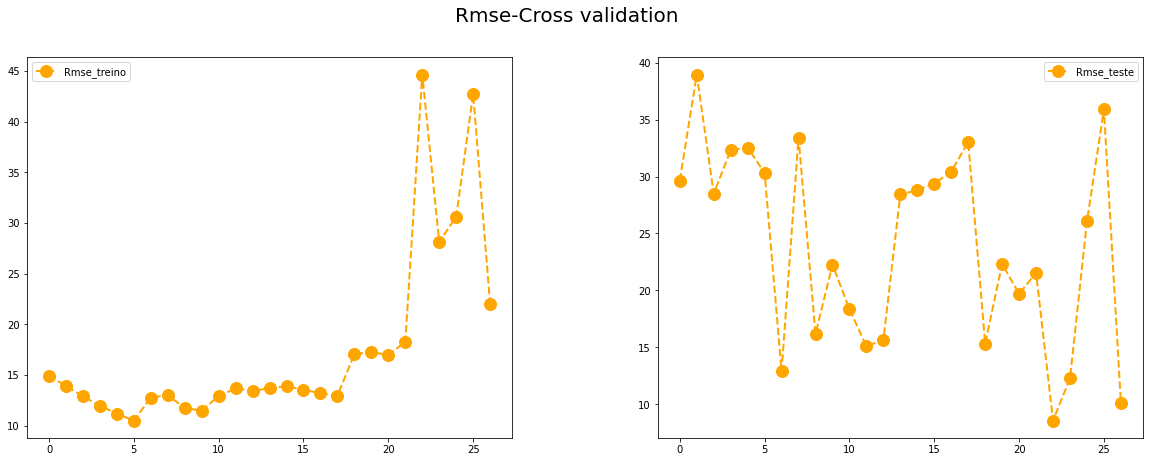

In [85]:
#Plotando o rmse ao londo do cross-validation
fig= plt.figure(figsize=(20,7))
plt.subplots_adjust(wspace=0.3,hspace=0.1)
fig.suptitle('Rmse-Cross validation', size= 20)
fig.add_subplot(1,2,1)
plt.plot(rmse_treino, label='Rmse_treino',color='orange', marker='o', linestyle='dashed',linewidth=2, markersize=12)
plt.legend()
fig.add_subplot(1,2,2)
plt.plot(rmse_teste, label='Rmse_teste',color='orange', marker='o', linestyle='dashed',linewidth=2, markersize=12)
plt.legend()

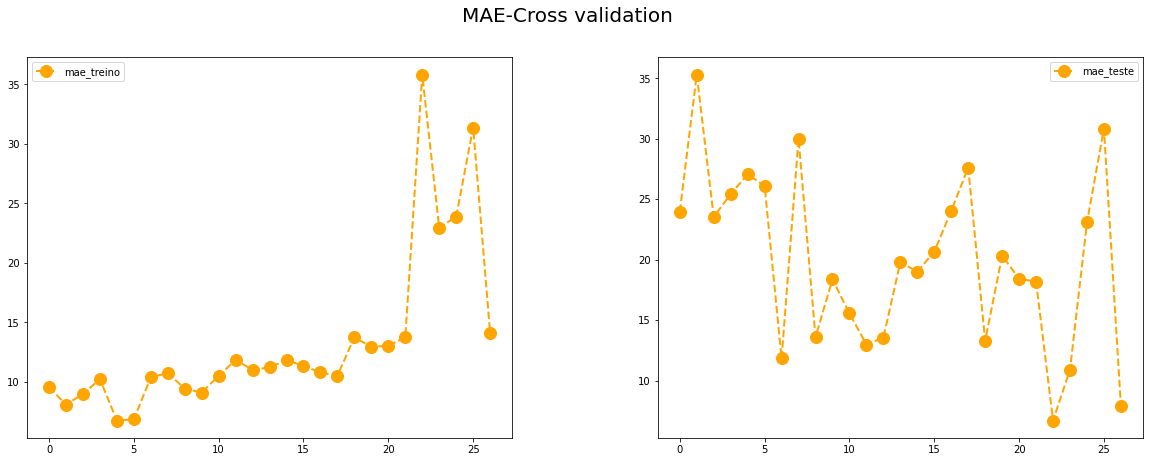

In [86]:
#Plotando o mae ao londo do cross-validation
fig= plt.figure(figsize=(20,7))
plt.subplots_adjust(wspace=0.3,hspace=0.1)
fig.suptitle('MAE-Cross validation', size= 20)
fig.add_subplot(1,2,1)
plt.plot(mae_treino, label='mae_treino',color='orange', marker='o', linestyle='dashed',linewidth=2, markersize=12)
plt.legend()
fig.add_subplot(1,2,2)
plt.plot(mae_test, label='mae_teste',color='orange', marker='o', linestyle='dashed',linewidth=2, markersize=12)
plt.legend()

Obtivemos uma média de RMSE de 24 e MAE de 19.93.

#9. Forecasting da quantidade de Vendas

Aqui temos, o nosso forecasting de vendas referente a 4 meses, juntamente com o intervalo de confiança de 95%

In [87]:
##Função para previsão de attrition
def forecast(model,predict_steps,y, x):
    
    pred_uc = model.get_forecast(steps=predict_steps, exog= x)

    ## Predição do intervalo de confiança do Sarimax, com o alpha de 0.05, correspondente a IC de 95%
    pred_ci = pred_uc.conf_int()

    ax = y.plot(label='observado', figsize=(14, 7))
    
    ## Print(pred_uc.predicted_mean)
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Data')
    ax.set_ylabel(y.name)

    plt.legend()
    plt.show()
    
    ## Tabela das predições do forecast
    pm = pred_uc.predicted_mean.reset_index()
    pm.columns = ['Data','Media_predicao']
    pci = pred_ci.reset_index()
    pci.columns = ['Data','Lower Bound','Upper Bound']
    final_table = pm.join(pci.set_index('Data'), on='Data')
    
    return (final_table)

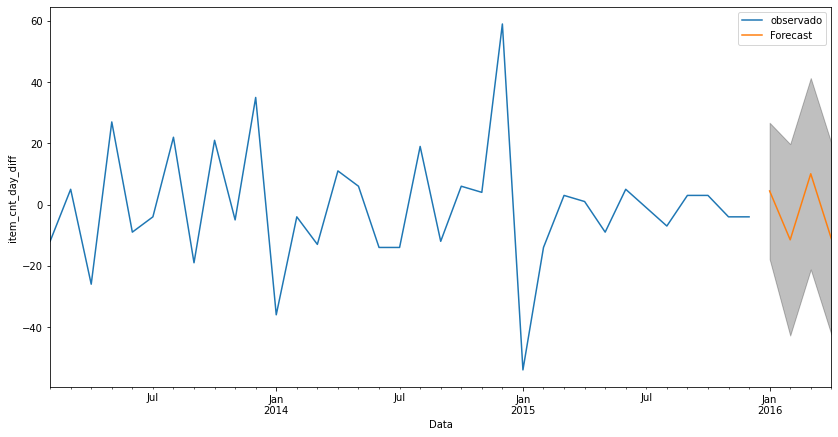

,Data,Media_predicao,Lower Bound,Upper Bound
0,2016-01-31,4.45464328,-17.83200392,26.74129048
1,2016-02-29,-11.50682682,-42.76548949,19.75183586
2,2016-03-31,10.07497280,-21.18368987,41.33363547
3,2016-04-30,-11.09298881,-42.35165148,20.16567386


In [88]:
resulta_forecast = forecast(res,4,y, x_test)
resulta_forecast

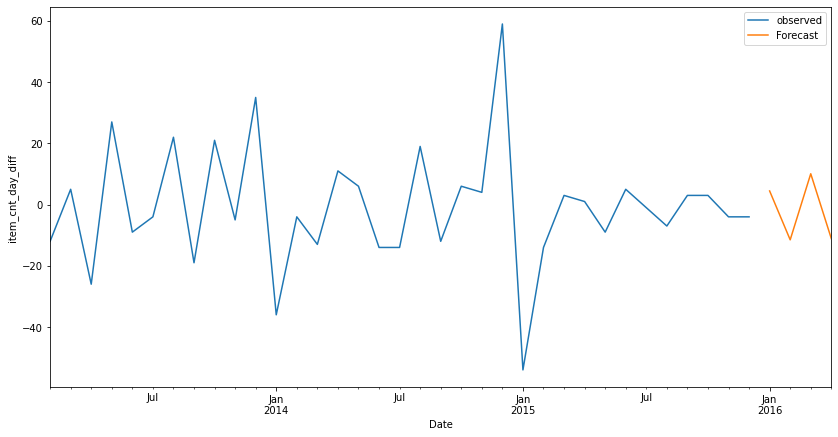


2016-01-31     4.45464328
2016-02-29   -11.50682682
2016-03-31    10.07497280
2016-04-30   -11.09298881
Freq: M, Name: predicted_mean, dtype: float64


In [89]:
## Prevendo só a média
pred_uc = res.get_forecast(steps=4, exog = x_test)
ax = y.plot(label='observed', figsize=(14, 7))

pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.set_xlabel('Date')
ax.set_ylabel(y.name)

plt.legend()
plt.show()
print()
print(pred_uc.predicted_mean)

#10. Melhor e Pior cenário das vendas

Aqui vamos fazer o melhor e o pior cenário de acordo com a média de erro do modelo para trazer uma visão melhor das previsões para o negócio.

In [90]:
# Criando a tabela
pred_media = pred_uc.predicted_mean.reset_index() #fazendo a previsão futura média das vendas
pred_media.columns = ['data_previsão','Media_predicao']
pred_media['Pior_Cenário'] = pred_media['Media_predicao'].map(lambda x: x - med_erro)
pred_media['Melhor_Cenário'] = pred_media['Media_predicao'].map(lambda x: x + med_erro)

In [91]:
pred_media

,data_previsão,Media_predicao,Pior_Cenário,Melhor_Cenário
0,2016-01-31,4.45464328,-15.47119631,24.38048287
1,2016-02-29,-11.50682682,-31.43266641,8.41901277
2,2016-03-31,10.07497280,-9.85086679,30.00081239
3,2016-04-30,-11.09298881,-31.01882840,8.83285078
